<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/Sensor0.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:

import os
from IPython.core.completer import time
from natsort import natsorted
from tensorflow.keras.preprocessing.image import (
    array_to_img,
    img_to_array,
    load_img,
)
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np


In [4]:
class GetLoader:
    def __init__(self, *, imgs, masks, timesteps, batch_size, squeeze=False):
        self.imgs = imgs
        self.masks = masks
        self.timesteps = timesteps
        self.batch_size = batch_size
        self.squeeze = squeeze
        self.augmentation = tf.keras.Sequential(
            [
                layers.RandomFlip("horizontal_and_vertical"),
                layers.RandomRotation(0.2),


            ]
        )

    def __iter__(self):
        return self

    def __next__(self):
        xs = []
        ys = []
        for _ in range(self.batch_size):
            index = np.random.randint(0, len(self.imgs) - self.timesteps)
            xs.append(self.imgs[index : index + self.timesteps])
            ys.append(self.masks[index + self.timesteps])
        x, y = np.array(xs), np.array(ys)
        x = x.squeeze(-1).transpose(0, 2, 3, 1)
        xy = self.augmentation(tf.concat((x, y), axis=-1))

        x = xy[:, :, :, :3]
        y = xy[:, :, :, 3:]
        if not self.squeeze:
            x = tf.transpose(x, perm=(0, 3, 1, 2))[..., None]
            y = tf.expand_dims(y, 1)
        # if not tf.reduce_all(y[0] == 0):
        #    ipdb.set_trace()
        return x, y


class DataLoader:
    def __init__(
        self,
        data_folder: str,
        *,
        timesteps: int = 3,
        batch_size=4,
        squeeze=False,
    ):
        self.batch_size = batch_size
        self.data_folder = data_folder
        self.timesteps = timesteps
        self.squeeze = squeeze
        train_img_file_names = [
            os.path.join(data_folder, "train_images", "images", fn)
            for fn in os.listdir(os.path.join(data_folder, "train_images", "images"))
        ]
        train_img_file_names = natsorted(train_img_file_names)
        # train_img_file_names.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
        train_mask_file_names = [
            fn.replace("images", "masks") for fn in train_img_file_names
        ]
        self.train_imgs = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in train_img_file_names
                ]
            )
            / 255
        )
        self.train_masks = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in train_mask_file_names
                ]
            )
            / 255
            > 0.5
        ).astype(float)

        val_img_file_names = [
            os.path.join(data_folder, "val_images", "images", fn)
            for fn in os.listdir(os.path.join(data_folder, "val_images", "images"))
        ]
        val_img_file_names = natsorted(val_img_file_names)
        val_mask_file_names = [
            fn.replace("images", "masks") for fn in val_img_file_names
        ]
        self.val_imgs = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in val_img_file_names
                ]
            )
            / 255
        )
        self.val_masks = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale"))
                    for fn in val_mask_file_names
                ]
            )
            / 255
            > 0.5
        ).astype(float)

    def get_loaders(self):
        return (
            GetLoader(
                imgs=self.train_imgs,
                masks=self.train_masks,
                timesteps=self.timesteps,
                batch_size=self.batch_size,
                squeeze=self.squeeze,
            ),
            GetLoader(
                imgs=self.val_imgs,
                masks=self.val_masks,
                timesteps=self.timesteps,
                batch_size=self.batch_size,
                squeeze=self.squeeze,
            ),
        )

In [5]:
train_loader, val_loader = DataLoader("/gdrive/MyDrive/adjustedROI/final_output", squeeze=False).get_loaders()


In [6]:
x, y = train_loader.__next__()

In [7]:
from matplotlib import pyplot as plt

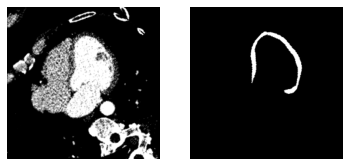

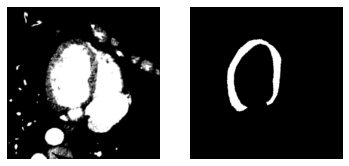

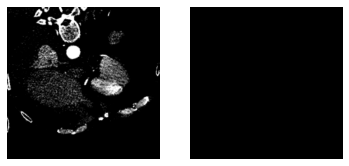

In [8]:
x, y = train_loader.__next__()

for i in range(0,3):
    image = x[i,0,:,:,0]
    #mask = np.argmax(y[i], axis=2)
    mask= y[i,0,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [9]:
x.shape

TensorShape([4, 3, 256, 256, 1])

In [10]:
y.shape


TensorShape([4, 1, 256, 256, 1])

In [11]:
batch_size=4

In [12]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('/gdrive/MyDrive/adjustedROI/final_output/train_images/images'))
num_val_images = len(os.listdir('/gdrive/MyDrive/adjustedROI/final_output/val_images/images'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, TimeDistributed,Dropout,Input, Dense,\
    BatchNormalization, GRU, Layer, Flatten,MaxPooling2D, concatenate,Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras import models
from tensorflow.python.keras.layers import ConvLSTM2D

In [14]:
input_shape=(3,256,256,1)

In [15]:
input_l = layers.Input(shape=(input_shape))
x =  (layers.TimeDistributed(layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1),activation='relu' ) )) (input_l)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
conv2 = layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1),activation='relu'  ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(conv2)

x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(x)
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1),activation='relu'   ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)
conv5 = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1),activation='relu'   ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(conv5)
x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(x)
x = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ,activation='relu'  ) ) (x)
x=layers.TimeDistributed(layers.BatchNormalization())(x)

conv8 = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ,activation='relu'  ) ) (x)
conv8=layers.TimeDistributed(layers.BatchNormalization())(conv8)

x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(conv8)

x=layers.Bidirectional(layers.ConvLSTM2D(256,kernel_size=(3,3),padding='same',strides=(1,1),return_sequences=True,recurrent_dropout=0.2))(x)
up1 = layers.TimeDistributed( layers.Conv2DTranspose( 512,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat1 = layers.concatenate([up1, conv8])
x = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ,activation='relu'  ) ) (concat1)
x = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ,activation='relu'  ) ) (x)
up2 = layers.TimeDistributed( layers.Conv2DTranspose( 256,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat2 = layers.concatenate([up2, conv5])
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1),activation='relu'   ) ) (concat2)
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1) ,activation='relu'  ) ) (x)
up3 = layers.TimeDistributed( layers.Conv2DTranspose( 128,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat3 = layers.concatenate([up3, conv2])
x = layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1),activation='relu'   ) ) (concat3)
x=layers.Bidirectional(layers.ConvLSTM2D(32,kernel_size=(3,3),padding='same',strides=(1,1),return_sequences=False,recurrent_dropout=0.2))(x)
x=tf.expand_dims(x,axis=1)

#out= layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(1, 1),padding='same',strides=(1,1),activation='relu' ,  ) ) (x)
#out = tf.reshape(out, (-1, 1, 256,256, 64))
out = layers.Conv2D( 1, kernel_size=(1, 1),padding='same',strides=(1,1), activation='sigmoid' )  (x)


model = models.Model(inputs=input_l, outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 256, 256  0           []                               
                                , 1)]                                                             
                                                                                                  
 time_distributed (TimeDistribu  (None, 3, 256, 256,  640        ['input_1[0][0]']                
 ted)                            64)                                                              
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 3, 256, 256,  256        ['time_distributed[0][0]']       
 buted)                          64)                                                          

In [16]:
from keras import backend as K


def dice_coefficient(y_true, y_pred, smooth=0.0001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)

    return ((2. * intersection + smooth) / (K.sum(y_true_f) +
            K.sum(y_pred_f) + smooth))


def dice_coefficient_loss(y_true, y_pred):
    return 1.0-dice_coefficient(y_true, y_pred)


def iou_loss(y_true, y_pred):
    return 1-iou(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum(K.square(y_true)) + K.sum(K.square(y_pred))
    jac = (intersection) / (sum_ - intersection)
    return jac

In [17]:
LR = 5e-5
optim = tf.keras.optimizers.Adam(LR)

In [18]:
metrics=['Recall','Precision', dice_coefficient, 'binary_accuracy']


In [19]:
model.compile(optimizer=optim, loss=dice_coefficient_loss, metrics=metrics)


In [20]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/gdrive/MyDrive/chk/',
    save_weights_only=True,
    monitor='val_dice_coefficient',
    mode='max',
    save_best_only=True)


In [ ]:
history=model.fit(train_loader,
          steps_per_epoch=steps_per_epoch,
          epochs=15,
          verbose=1,
          validation_data=val_loader,
          callbacks=model_checkpoint_callback,

    
          validation_steps=val_steps_per_epoch)

Epoch 1/15
745/745 [==============================] - 1228s 2s/step - loss: 0.5634 - recall: 0.6276 - precision: 0.2839 - dice_coefficient: 0.4366 - binary_accuracy: 0.9489 - val_loss: 0.4989 - val_recall: 0.5414 - val_precision: 0.5673 - val_dice_coefficient: 0.5011 - val_binary_accuracy: 0.9703
Epoch 2/15
745/745 [==============================] - 1194s 2s/step - loss: 0.4691 - recall: 0.6647 - precision: 0.5590 - dice_coefficient: 0.5309 - binary_accuracy: 0.9772 - val_loss: 0.4095 - val_recall: 0.5169 - val_precision: 0.7687 - val_dice_coefficient: 0.5905 - val_binary_accuracy: 0.9768
Epoch 3/15
745/745 [==============================] - 1193s 2s/step - loss: 0.4146 - recall: 0.6824 - precision: 0.6310 - dice_coefficient: 0.5854 - binary_accuracy: 0.9805 - val_loss: 0.3863 - val_recall: 0.6110 - val_precision: 0.7104 - val_dice_coefficient: 0.6137 - val_binary_accuracy: 0.9789
Epoch 4/15
745/745 [==============================] - 1193s 2s/step - loss: 0.3862 - recall: 0.7061 - prec